# Need for Slicing

The dataset is of huge size and causing kernel crash , reduction in dimensionality and overall size.

In [11]:
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [12]:
from datetime import datetime
globalstart = datetime.now()

In [41]:
raw_data_path = "./data/raw"
movie_titles_csv_path = raw_data_path + "/movie_titles.csv"

processed_data_path = "./data/processed"
models_path = "./models"
master_data_csv_path = processed_data_path + "/" + "data.csv"

In [42]:
# Loading full dataset

start = datetime.now()
print("creating the dataframe from data.csv file..")
ratings = pd.read_csv(master_data_csv_path, sep=',', names=['movieId', 'userId','rating','date'])
ratings.date = pd.to_datetime(ratings.date)
print('Done.\n')

print(datetime.now() - start)

# arranging the ratings according to time.
print('Sorting the dataframe by date..')
ratings.sort_values(by='date', inplace=True)
print('Done..')

print("Time taken :", datetime.now() - start)


creating the dataframe from data.csv file..
Done.

0:00:45.240171
Sorting the dataframe by date..
Done..
Time taken : 0:01:21.390898


In [43]:
ratings.head(2)

,movieId,userId,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11


In [44]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:n]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:n]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [45]:

tabular_preview(ratings=ratings, n=15)

movieId,1905,2152,5317,6287,6972,9340,11283,12317,12470,14313,15124,15205,15582,16242,16377
userId,,,,,,,,,,,,,,,
305344,1.0,3.0,2.0,4.0,4.0,5.0,1.0,4.0,4.0,2.0,5.0,2.0,4.0,4.0,5.0
387418,4.0,4.0,4.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,4.0
491531,5.0,5.0,1.0,3.0,5.0,4.0,5.0,3.0,3.0,1.0,5.0,5.0,1.0,2.0,5.0
752642,5.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,2.0,3.0,2.0,4.0,3.0,3.0,3.0
1114324,5.0,3.0,3.0,2.0,4.0,3.0,5.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0
1314869,4.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,4.0
1461435,4.0,1.0,2.0,1.0,2.0,2.0,4.0,3.0,4.0,4.0,3.0,3.0,1.0,3.0,4.0
1639792,4.0,1.0,1.0,4.0,2.0,1.0,1.0,3.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0
1663888,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Checking and Visualising the current numbers

In [46]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

In [47]:
no_user_voted.shape, no_movies_voted.shape

((17770,), (480189,))

#### Visualizing Number of Users voted Vs movies and threshold of 10 votes

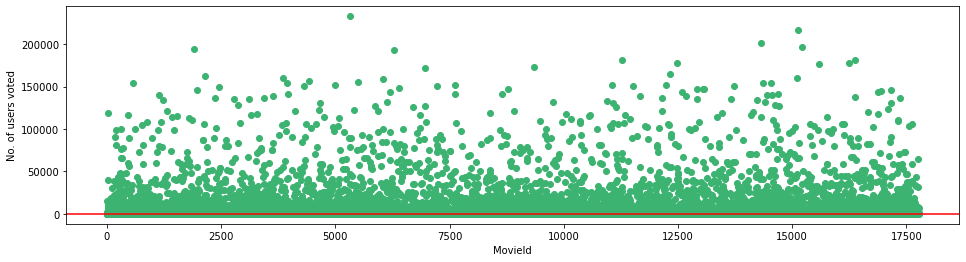

In [48]:
f,ax = plt.subplots(1,1,figsize=(16,4))

plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()



#### Visualizing Number of votes by users vs Users and threshold of 50

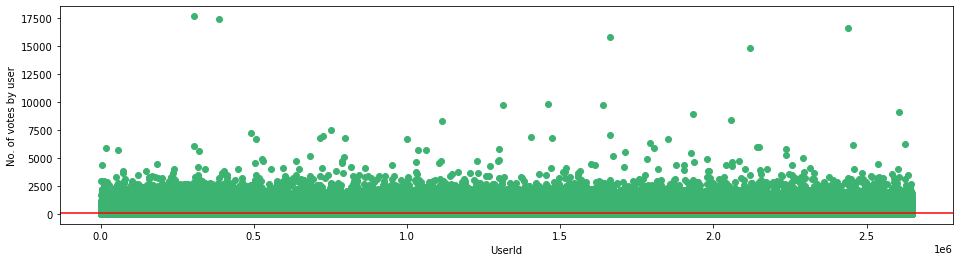

In [49]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()



## Dimensionality Method 

In [51]:

start = datetime.now()

# min_ratings_movie = 100
min_ratings_movie = 50000
filter_items = ratings['movieId'].value_counts() > min_ratings_movie
filter_items = filter_items[filter_items].index.tolist()

# min_ratings_by_user = 100
min_ratings_by_user = 1500
filter_users = ratings['userId'].value_counts() > min_ratings_by_user
filter_users = filter_users[filter_users].index.tolist()

ratings_new = ratings[(ratings['movieId'].isin(filter_items)) & (ratings['userId'].isin(filter_users))]
print('The original data frame shape:\t({:,}, {})'.format(ratings.shape[0], ratings.shape[1]))
print('The new data frame shape:\t({:,}, {})'.format(ratings_new.shape[0], ratings_new.shape[1]))

print("Time taken:", datetime.now() - start)

The original data frame shape:	(100,480,507, 4)
The new data frame shape:	(1,438,653, 4)
Time taken: 0:00:09.492046


## Saving the Filtered/Sliced Ratings Data

In [53]:
ratings_new.head(2)

,movieId,userId,rating,date
91241995,16242,2248080,3,1999-12-30
60247453,11064,2248080,3,1999-12-30


In [55]:
ratings_new.to_csv(processed_data_path + "/" + "data_sliced.csv", index=False)


## Spliting sliced data into Train and Test(80:20)

In [56]:
start = datetime.now()

if not os.path.isfile('train_sliced.csv'):
    
    ratings_new.iloc[:int(ratings_new.shape[0]*0.80)].to_csv(processed_data_path + "/" + "train_sliced.csv", index=False)

if not os.path.isfile('test_sliced.csv'):
    
    ratings_new.iloc[int(ratings_new.shape[0]*0.80):].to_csv(processed_data_path + "/" + "test_sliced.csv", index=False)
    
print("Time taken:", datetime.now() - start)

Time taken: 0:00:08.966636


In [57]:
ratings_new2 = pd.read_csv(processed_data_path + "/" + "data_sliced.csv")
ratings_new2.head()

,movieId,userId,rating,date
0,16242,2248080,3,1999-12-30
1,11064,2248080,3,1999-12-30
2,7399,2248080,2,1999-12-30
3,4670,2248080,3,1999-12-30
4,6287,2248080,2,1999-12-30


In [58]:
train_sliced2 = pd.read_csv(processed_data_path + "/" + "train_sliced.csv")
train_sliced2.head(2)

,movieId,userId,rating,date
0,16242,2248080,3,1999-12-30
1,11064,2248080,3,1999-12-30


In [59]:
test_sliced2 = pd.read_csv(processed_data_path + "/" + "test_sliced.csv")
test_sliced2.head(2)

,movieId,userId,rating,date
0,5695,789969,4,2005-03-25
1,7230,974823,5,2005-03-25


## FIltering/Slicing the Movies Titles List

In [60]:
movies = pd.read_csv(movie_titles_csv_path, names=['movieId', 'year_of_release', 'title'])
movies.head(2)

,movieId,year_of_release,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review


In [61]:
movies.head()

,movieId,year_of_release,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [62]:
movie_ids = ratings_new['movieId'].unique()

In [63]:
movies_new = movies[movies['movieId'].isin(movie_ids)]

In [64]:
movies.shape, movies_new.shape

((17770, 3), (501, 3))

In [65]:
movies_new.head()

,movieId,year_of_release,title
29,30,2003.0,Something's Gotta Give
174,175,1992.0,Reservoir Dogs
190,191,2003.0,X2: X-Men United
196,197,2004.0,Taking Lives
298,299,2001.0,Bridget Jones's Diary


In [66]:
movies_new[movies_new.movieId==16242]

,movieId,year_of_release,title
16241,16242,1997.0,Con Air


## Saving the Sliced/Filtered Movies Titles list

In [67]:
movies_new.to_csv(processed_data_path + "/" + 'movies_sliced.csv', index=False)

movies_new2 = pd.read_csv(processed_data_path + "/" +  'movies_sliced.csv')
movies_new2.head()

,movieId,year_of_release,title
0,30,2003.0,Something's Gotta Give
1,175,1992.0,Reservoir Dogs
2,191,2003.0,X2: X-Men United
3,197,2004.0,Taking Lives
4,299,2001.0,Bridget Jones's Diary


In [68]:
print("Total Time taken :", datetime.now()-globalstart)

Total Time taken : 0:38:41.656256
